# How-To: Control a Poppy Humanoid in a Simulator using a Python lib: [pypot](https://github.com/poppy-project/pypot)

<img src="image/vrep-header.png" alt="V-REP header" style="height: 400px;"/>

## Introduction

In this notebook, we will present how a simulated [Poppy Humanoid](https://github.com/poppy-project/poppy-humanoid) - an open-source and 3D printed humanoid robot - can be controlled in real time. The robot will be simulated in [V-REP](http://www.coppeliarobotics.com) a well known and powerful robot simulator. In this tutorial we will show how to **install**, **use**, and **program** the simulated robot in [Python](https://www.python.org). To do that, we will use the [pypot](https://github.com/poppy-project/pypot) library developed to easily control and program Poppy Creatures.

###**To install the software tools on your machine, we strongly recommend using [Anaconda](https://store.continuum.io/cshop/anaconda/) the scientific python distributions. It comes with all poppy dependencies pre-compiled and works great on Windows, Mac, Linux! We advise you to use the 2.7 version.**

In more details, we will:
* see how we can **create a poppy humanoid in the V-REP simulator**
* learn how we can **read/send values to the motors**
* **track** one or several Poppy's parts 3D **position and orientation** (e.g. its head)
* write a **simple primitive** to design higher level behaviors (e.g. a dance motion)
* see how we can **reset** and tune the simulation

<img src="https://raw.githubusercontent.com/poppy-project/poppy-humanoid/master/doc/img/poppy-humanoid-github.jpg" alt="Poppy Humanoid" style="height: 500px;"/>

*Note: Most of the tutorial is redundant with the ones on how to control a "real" poppy creature. In particular, switching from a real robot to a simulated one (and vice versa) can be done just by changing a single line of code (see the [appendix]() at the end of this notebook). Furthermore, most of the notebook can be applied to any [Poppy Creature](https://www.poppy-project.org/technologies/) (and even any "[pypot robot](http://poppy-project.github.io/pypot/pypot.robot.html#pypot.robot.robot.Robot)"), only the instantiation method will change.*

**Comments, issues, improvements and updates can be sent directly on the dedicated section of the [github issue tracker](https://github.com/poppy-project/pypot/labels/Notebooks).**

### What's needed?

**First, if you do not know how to run an IPython Notebook please refer to [our readme](https://github.com/poppy-project/pypot/blob/master/samples/notebooks/readme.md#notebooks-everywhere).**

To follow this tutorial you will need:
* a [Python](https://www.python.org) interpreter (2.7 is recommended but 3.4 or pypy-2.5 should also work). **We strongly recommand to use a pre-packaged Python distribution such as [Anaconda](https://store.continuum.io/cshop/anaconda/).**
* the [V-REP](http://www.coppeliarobotics.com) simulator (please directly see [v-rep download section](http://www.coppeliarobotics.com/downloads.html) for installation details)
* the python [pypot](https://github.com/poppy-project/pypot) library version >= 2.1
* the [poppy_humanoid](https://github.com/poppy-project/Poppy-Humanoid) software library >= 1.0

Both V-REP and the pypot/poppy libraries are open source and cross platform.

The pypot and poppy_humanoid library can be installed via [pip](https://python-packaging-user-guide.readthedocs.org/en/latest/projects.html#pip) - a tool for installing Python Package **(if you have no idea what pip is or how to run the following command, please refer to [our readme](https://github.com/poppy-project/pypot#installation) first :-))**:

```bash
pip install pypot poppy_humanoid
```

You can also install them from the [source](https://github.com/poppy-project/poppy-humanoid/tree/master/software) and then use the classical:

```bash
python setup.py install
```

*Note: installing poppy_humanoid will also install pypot as it is one of the depencies.*

### Checking your installation

To check if everything is installed correctly, you can run the following code. If it runs without raising an error, everything is probably installed correctly:

**You can run IPython Notebook code cells by selecting them and clicking the play button or by pressing shift+enter.**

In [4]:
from pypot.vrep import from_vrep
from poppy.creatures import PoppyHumanoid

If you have any installation issue, please check [our forum](https://forum.poppy-project.org) or the [github issue tracker](https://github.com/poppy-project/pypot/labels/Notebooks).

## Instantiating a [Poppy Humanoid](https://www.poppy-project.org/creatures/poppy-humanoid/)

In this section, we will see how a Poppy Humanoid can be created into V-REP and how we can connect it to a [pypot Robot](http://poppy-project.github.io/pypot/pypot.robot.html): i.e. the object used in pypot to represent and communicate with a robot.

First, you will need to launch V-REP (please refer to [V-REP documentation](http://www.coppeliarobotics.com/helpFiles/index.html) if you don't know how to do it). Once it's done you should see something like:

<img src="image/vrep-screenshot.png" alt="V-REP Empty Scene" style="height: 500px;"/>

Instead of loading a specific scene with a Poppy humanoid through the V-REP GUI and then connect to it using pypot, we will directly instantiate the [PoppyHumanoid](https://github.com/poppy-project/Poppy-Humanoid) class which will do most of the work for us.

In particular, it will:
* load a V-REP scene with a Poppy Humanoid
* instantiate a [pypot Robot](http://poppy-project.github.io/pypot/pypot.robot.html) and connect it to the simulated Poppy

To do that, we will use the following code:

In [5]:
from poppy.creatures import PoppyHumanoid

poppy = PoppyHumanoid(simulator='vrep')

You should now see a Poppy in your V-REP window:

<img src="image/vrep-poppy.png" alt="V-REP Poppy Humanoid Scene" style="height: 500px;"/>

**Note: Be careful that VREP is often displaying pop-up that freezes the communication with pypot. You will have to close them otherwise a timeout will occur!**

## Controlling motors

As soon as you have instantiated a [Robot](http://poppy-project.github.io/pypot/pypot.robot.html#pypot.robot.robot.Robot) - in our case through the [PoppyHumanoid](https://github.com/poppy-project/Poppy-Humanoid) class - it is synced with the simulation (or the real robot). This means that values from the V-REP simulation (e.g. limbs position) are retrieved from the simu and affected to their equivalent variables by a synchronization loop. Similarly target variables (e.g. motors goal position) are sent to V-REP. This synchronization loop runs at 50Hz by default.

To be more clear, when reading a variable from the *poppy* object you will obtain the last synced value from V-REP and when setting a new value to a *poppy* variable it will be automatically sent to V-REP a short time after. You never need to manually sync your instance with the current state of the simulation, it is automatically done by a thread running in background.

### Accessing motors registers

Dynamixel motors comes with a [lot of registers](http://support.robotis.com/en/product/dynamixel/mx_series/mx-28.htm) which are used to store the current state of the robot (its current position, temperature, pid gains...) but also where you can write new target values, for instance a new goal position.

 In this section we will see how pypot give you an high-level access to the most frequently used registers ([pypot low-level IO](http://poppy-project.github.io/pypot/dynamixel.html) gives you an access to all registers but this is beyond the scope of this tutorial).

So, first we will retrieve the list of all available motors. The [motors](http://poppy-project.github.io/pypot/pypot.robot.html#pypot.robot.robot.Robot.motors) variable contains the list of all motors attached to the current robot. 

<img src="https://forum.poppy-project.org/uploads/default/80/267da75bd9feeab2.jpg" alt="Poppy Humnanoid Motors" style="height: 500px;"/>

By default, each motor prints its name, its id, and its current position:

In [6]:
poppy.motors

[<DxlMotor name=l_hip_x id=11 pos=-0.3>,
 <DxlMotor name=r_hip_x id=21 pos=0.3>,
 <DxlMotor name=l_arm_z id=43 pos=0.0>,
 <DxlMotor name=r_ankle_y id=25 pos=0.1>,
 <DxlMotor name=r_arm_z id=53 pos=0.0>,
 <DxlMotor name=r_knee_y id=24 pos=0.0>,
 <DxlMotor name=r_hip_y id=23 pos=-0.0>,
 <DxlMotor name=bust_y id=34 pos=0.1>,
 <DxlMotor name=r_elbow_y id=54 pos=0.0>,
 <DxlMotor name=r_hip_z id=22 pos=0.0>,
 <DxlMotor name=l_ankle_y id=15 pos=0.1>,
 <DxlMotor name=head_z id=36 pos=-0.0>,
 <DxlMotor name=abs_y id=31 pos=0.1>,
 <DxlMotor name=r_shoulder_x id=52 pos=-1.0>,
 <DxlMotor name=r_shoulder_y id=51 pos=0.0>,
 <DxlMotor name=l_shoulder_x id=42 pos=0.20000000000000284>,
 <DxlMotor name=bust_x id=35 pos=0.0>,
 <DxlMotor name=l_shoulder_y id=41 pos=-0.29999999999999716>,
 <DxlMotor name=abs_z id=33 pos=0.0>,
 <DxlMotor name=l_hip_y id=13 pos=-2.0>,
 <DxlMotor name=abs_x id=32 pos=0.0>,
 <DxlMotor name=l_hip_z id=12 pos=-0.0>,
 <DxlMotor name=l_knee_y id=14 pos=-0.0>,
 <DxlMotor name=l_elb

You can access a specific motor directly using its name:

In [8]:
poppy.l_shoulder_y

<DxlMotor name=l_shoulder_y id=41 pos=-0.29999999999999716>

If we want to get the current position (in degrees) of a specific motor (e.g. *head_y*) we can use:

In [7]:
poppy.head_y.present_position

-1.8000000000000007

You can also use the list/dict comprehension to retrieve a specific value for all motors.

A list of all current motor positions:

In [9]:
[m.present_position for m in poppy.motors]

[-0.29999999999999999,
 0.29999999999999999,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 -0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.10000000000000001,
 -0.0,
 0.10000000000000001,
 -1.0,
 0.0,
 0.20000000000000284,
 0.0,
 -0.29999999999999716,
 0.0,
 -2.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 -1.8000000000000007]

A dictionary of pairs {motor_name: motor_position}:

In [10]:
{m.name: m.present_position for m in poppy.motors}

{'abs_x': 0.0,
 'abs_y': 0.10000000000000001,
 'abs_z': 0.0,
 'bust_x': 0.0,
 'bust_y': 0.10000000000000001,
 'head_y': -1.8000000000000007,
 'head_z': -0.0,
 'l_ankle_y': 0.10000000000000001,
 'l_arm_z': 0.0,
 'l_elbow_y': 0.0,
 'l_hip_x': -0.29999999999999999,
 'l_hip_y': -2.0,
 'l_hip_z': -0.0,
 'l_knee_y': -0.0,
 'l_shoulder_x': 0.20000000000000284,
 'l_shoulder_y': -0.29999999999999716,
 'r_ankle_y': 0.10000000000000001,
 'r_arm_z': 0.0,
 'r_elbow_y': 0.0,
 'r_hip_x': 0.29999999999999999,
 'r_hip_y': -0.0,
 'r_hip_z': 0.0,
 'r_knee_y': 0.0,
 'r_shoulder_x': -1.0,
 'r_shoulder_y': 0.0}

### Motor alias or group of motors

In pypot we use the concept of motor alias which is simply a list of motors grouped together under a specific name. For instance, you can directly access all the motors from the torso using the *torso* alias. Poppy Humanoid also defines a *leg* alias, a *left arm* alias...

Note, that *motors* used above is just one of the predefined motors alias - one with all attached motors. 

You can retrieve the list of motors alias available using:

In [8]:
poppy.alias

[u'r_leg',
 u'torso',
 u'l_leg_sagitall',
 u'head',
 u'l_arm',
 u'r_leg_sagitall',
 u'l_leg',
 u'arms',
 u'legs',
 u'r_arm']

Each alias contains a list of motors. Thus, you can similarly retrieve all positions for only the motors of the right leg:

In [13]:
{m.name: m.present_position for m in poppy.r_leg}

{'r_ankle_y': 0.10000000000000001,
 'r_hip_x': 0.29999999999999999,
 'r_hip_y': -0.0,
 'r_hip_z': 0.0,
 'r_knee_y': 0.0}

### Setting registers

In a similar way that you retrieve values from V-REP, you can set a new target position to a motor.

By sending the following command, you should see the robot turns its head of 90°:

In [17]:
poppy.head_z.goal_position = 90.

Or you can affect new target positions for a group of motors:

In [12]:
for m in poppy.l_arm:
    m.goal_position = 30.

It's important to note the difference between the current and goal position. In particular, when setting a new goal position, it will take time before the motor actually reaches the desired position (see section below for an example).

Thus, in the code below only the second instruction will likely have an effect on the robot:

In [12]:
poppy.r_shoulder_x.goal_position = 30
poppy.r_shoulder_x.goal_position = -30

*Note: While the full list of motor registers is available, not all of them are having an effect in the V-REP simulation. For instance, modifying the pid of a motor won't affect the simulation.*

*Currently in the V-REP simulator you can use:*

* **present_position** *(R): the actual position of the motor (usually from -180° to 180°)*
* **goal_position** *(RW): the target position of the motor, that is to say the position it will try to reach (same range and units than the present position)*
* **present_load** *(R): the current load applied on the motor (expressed in % of the max supported load)*
* **torque_limit** *(RW): the maximum torque that a motor can applied (also expressed in % of the max supported load)*
* **compliant** *(RW): whether the motor is compliant: if it resits or not when manually turned*
* **angle_limit** *(R): the position limits (lower and upper) of the motor. Some motors are restrained to a smaller position range to avoid breaking other parts.*

*Support for additional features may be added in future version.*

### Goto position

You can also use the [goto_position](http://poppy-project.github.io/pypot/pypot.dynamixel.html#pypot.dynamixel.motor.DxlMotor.goto_position) method (both at the robot or motor level) to get more control over the trajectory of a motor. In the examples above, when affecting the [goal_position](http://poppy-project.github.io/pypot/pypot.dynamixel.html#pypot.dynamixel.io.DxlIO.get_goal_position) the motor will try to reach it as fast as the [moving_speed](http://poppy-project.github.io/pypot/pypot.dynamixel.html#pypot.dynamixel.io.DxlIO.get_moving_speed) permits it. 

At the moment, [goto_position](http://poppy-project.github.io/pypot/pypot.dynamixel.html#pypot.dynamixel.motor.DxlMotor.goto_position) comes with two behaviors:
* *dummy:* just adjust the moving_speed so the goal_position is reached at the predefined timestamp (not always very accurate)
* *minjerk:* using the [minimum jerk](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MinimumJerkHypothesis.ipynb) to compute a smoother trajectory.

First, let's restart the simulation:

In [25]:
poppy.reset_simulation()

Now, we make the head move towards -45° in 2 seconds:

In [16]:
poppy.head_z.goto_position(-45, 2)

Goto position also comes with a wait arguments, so you can easily link motions (*wait=True* will wait for the movement to finish before executing the next line, while *wait=False* will send the new target position order and directly jump to the next instruction):

In [15]:
poppy.head_z.goto_position(45, 2, wait=False)
poppy.head_y.goto_position(-30, 2, wait=True)

poppy.head_z.goto_position(0, 2, wait=True)

poppy.head_y.goto_position(20, 1, wait=True)

You can get and set a new *goto_behavior* through the property:

In [16]:
poppy.head_y.goto_behavior

'minjerk'

In [17]:
poppy.head_y.goto_behavior = 'dummy'

### Read and Write

Let's prepare another example where we will illustrate the difference between present and goal position by applying a sinusoid on a specific motor.

To make sure the robot is in a stable position, we will reset the simulation. This will re-positioned the robot in its initial position:

In [18]:
poppy.reset_simulation()

Now let's make the robot's head moves:

In [26]:
import time

import math

amp = 30 # in degrees
freq = 0.5 # in Hz

t0 = time.time()

while True:
    t = time.time()
    
    # run for 10s
    if t - t0 > 10:
        break

    poppy.head_z.goal_position = amp * math.sin(2 * 3.14 * freq * t)
    
    time.sleep(0.04)

Now we will use the same code but we will record both the current and goal position:

In [27]:
current, goal = [], []

t0 = time.time()

while True:
    t = time.time()
    
    # run for 5s
    if t - t0 > 5:
        break

    poppy.head_z.goal_position = amp * math.sin(2 * 3.14 * freq * t)

    
    current.append(poppy.head_z.present_position)
    goal.append(poppy.head_z.goal_position)
    
    time.sleep(0.04)

If we plot the two trajectories, we can clearly see a time shift representing the time needed by the motor to reach the desired position: 

Populating the interactive namespace from numpy and matplotlib


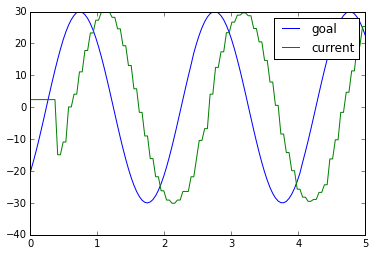

In [29]:
%pylab inline

t = linspace(0, 5, len(current))
plot(t, goal)
plot(t, current)

legend(('goal', 'current'))

Similarly, we can observe a goto position using the *minimum jerk* mode which shows the smooth acceleration and deceleration:

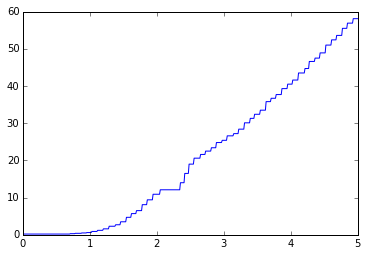

In [35]:

poppy.l_shoulder_x.goto_behavior = 'minjerk'

poppy.l_shoulder_x.goto_position(120, 5)

pos = []
t0 = time.time()

while time.time() - t0 < 5:
    pos.append(poppy.l_shoulder_x.present_position)
    
    time.sleep(0.01)
    
t = linspace(0, 5, len(pos))
plot(t, pos)

In [34]:
poppy.reset_simulation()

## Tracking objects

Using a V-REP simulated robot, you can easily retrieve an object position and orientation. You just need to know its name in the vrep scene.

*Note: at the moment to know the name of object in the vrep scene, you have to look for them in the v-rep window. Hopefully in future version of pypot, you will be able to directly retrieve them.*

<img src="image/vrep-finding-names.png" alt="Finding name of objects in a V-REP scene" style="height: 350px;"/>

For instance, to get the 3D position of the left hand, you just have to do:

In [24]:
poppy.get_object_position('l_forearm_visual')

[0.09879576414823532, 0.009888313710689545, 0.4137122929096222]

By default, the position is in the V-REP scene referential (the zero is somewhere between Poppy Humanoid's feet). You can use any object as referential and thus get the *left forearm* position related to the *head* for instance:

In [25]:
poppy.get_object_position('l_forearm_visual', 'head_visual')

[-0.18214008212089539, -0.27985879778862, -0.09438711404800415]

This can be used for discovering a reachable space for instance:

In [26]:
reached_pt = []

for m in poppy.l_arm:
    m.goto_behavior = 'minjerk'

# We generate 25 random arm configuration
# and stores the reached position of the forearm
for _ in range(25):
    poppy.reset_simulation()
    
    # Generate a position by setting random position (within the angle limit) to each joint
    # This can be hacked to define other exploration
    pos = {m.name: randint(min(m.angle_limit), max(m.angle_limit)) for m in poppy.l_arm}    
    poppy.goto_position(pos, 2., wait=True)
        
    reached_pt.append(poppy.get_object_position('l_forearm_visual'))

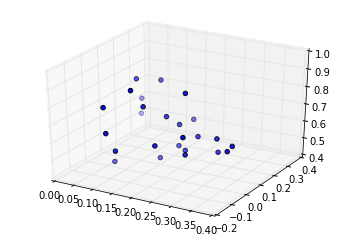

In [27]:
from mpl_toolkits.mplot3d import Axes3D

ax = axes(projection='3d')
ax.scatter(*array(reached_pt).T)

This example could be extended to show a simple method to build an inverse model (you build a table with many goals in the search space associated with the motor command which generated it, and for the inverse model you reproduce the motor command of the stored goal closest to the point you want to reach).

This could be a very good exercise where in a specific notebook you describe a simple approach to build and use approximated inverse models. 

If you are interested in this kind of experiments and want to go further, you can see the [explauto](https://github.com/flowersteam/explauto) library. It provides a unified framework for autonomous exploration experiment notably using a Poppy Creature. You will find there learning algorithms that can be used to learn forward (e.g. where the end position of an arm is depending on each joints position) and inverse model (finding the joint angles to locate the end effector at a desired position).

In [28]:
poppy.reset_simulation()

## Using primitives

Pypot also comes with the [Primitive](http://poppy-project.github.io/pypot/primitive.html) abstraction. The idea is to write simple behaviors that can be automatically combined to create more complex behaviors. As the primitive is likely to change in the future, and go toward something better defined, we will only show the very basic stuff you can do using primitives.

In more technical details, a primitive is only a thread which have access to all robot sensors and effectors. A [primitive manager](http://poppy-project.github.io/pypot/pypot.primitive.html#module-pypot.primitive.manager) is used to gather all primitives orders and combined them using a filter (a simple sum by default).

As an example of how to use primitives, we will use one of the predefined primitives, the [Sinus](http://poppy-project.github.io/pypot/pypot.primitive.html#pypot.primitive.utils.Sinus):

In [29]:
from pypot.primitive.utils import Sinus

Primitives are usually instantiated with a robot as the first argument. As Sinus is a [LoopPrimitive](http://poppy-project.github.io/pypot/pypot.primitive.html#pypot.primitive.primitive.LoopPrimitive) (i.e. a specific primitive which call an update method at a predefined frequency), you also need to pass the call frequency as the second argument).

The other arguments, here the motors list, the amplitude and the frequency are specific to the [Sinus](http://poppy-project.github.io/pypot/pypot.primitive.html#pypot.primitive.utils.Sinus) primitive.

In [30]:
sin_1 = Sinus(poppy, 25., [poppy.head_z, poppy.head_y], amp=15, freq=.15)

A primitive can be:
* started (re-started)
* stopped
* paused
* resumed

By running the following code, you should see both motors of the head performs a sinusoid.

In [31]:
sin_1.start()

Multiples primitives can be runned at the same time:

In [32]:
sin_2 = Sinus(poppy, 25., [poppy.head_z, ], amp=8, freq=.5)
sin_2.start()

We will now write a simple motor position logger using a loop primitive:

In [33]:
from pypot.primitive import LoopPrimitive

class MotorPositionLogger(LoopPrimitive):
    def __init__(self, robot, refresh_freq, motor):
        LoopPrimitive.__init__(self, robot, refresh_freq)
        
        self.motor = getattr(self.robot, motor.name)

    # This code will be called each time the primitive is started
    def setup(self):
        self.positions = []
       
    # This method will be called at the predefined frequency
    def update(self):
        self.positions.append(self.motor.present_position)

In [34]:
logger = MotorPositionLogger(poppy, 50, poppy.head_z)

We will illustrate the combination of primitives by pausing one of them in the middle of the recording:

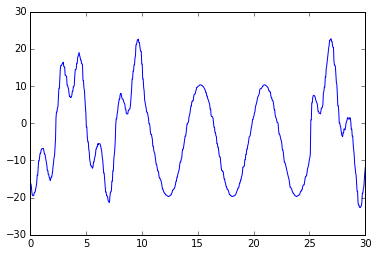

In [35]:
logger.start()

time.sleep(10)
sin_2.pause()

time.sleep(15)
sin_2.resume()

time.sleep(5)
logger.stop()

pos = logger.positions

plot(linspace(0, 30, len(pos)), pos)

You can see on the plot above, that the two sinusoids are combined from 0 to 10 and from 25 to 30. From 10 to 25 only one of the sinusoid is applied.

Now we stop all running primitives:

In [36]:
for p in poppy.active_primitives:
    p.stop()

# Appendix: switching from a simulated poppy to a real one

As mentionned in the introduction, most of the code above can be run on a "real" robot. All you need to change is the way the robot is instantiated. 

You have to replace:

```python
poppy = PoppyHumanoid(simulator='vrep')
```

by 

```python
poppy = PoppyHumanoid()
```

Of course, some of the directly V-REP related code - such as *reset_simulation* or *get_object_position* does not have any direct equivalent on the real robot. But all the rest should work and give about the same results on the real or the simulated robot.